<a href="https://colab.research.google.com/github/al34n1x/DataScience/blob/master/8.Machine_Learning/descriptores/2.image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmentación de imágenes

Normalmente, para extraer características basadas en descriptores de forma, es necesario, llevar a cabo alguna técnica de segmentación que permita delimitar la región de interés que se desea analizar.

Los algoritmos de segmentación se basan en particionar la imagen digital en diferentes segmentos (objetos) para simplificar la representación de la imagen y facilitar la comprensión de su contenido. 

Las técnicas de segmentación permiten asignar una etiqueta a cada píxel de la imagen de manera que los píxeles con la misma etiqueta comparten características similares. 

Existen dos tipos de segmentaciones:

- Segmentación semántica. Consiste en un problema de clasificación a nivel de píxel que permite asignar una etiqueta de objeto a cada píxel para delimitar regiones de interés. Por ejemplo, diferenciar un grupo de personas del fondo de la imagen. 
- Segmentación de instancia. Consiste en una tarea más compleja que implica llevar a cabo una detección de objetos para asignar una etiqueta de instancia a cada objeto. Es decir, la segmentación de instancia permite identificar objetos que comparten las mismas propiedades como objetos independiente. Por ejemplo, diferenciar cada persona de un grupo de personas en una imagen. 
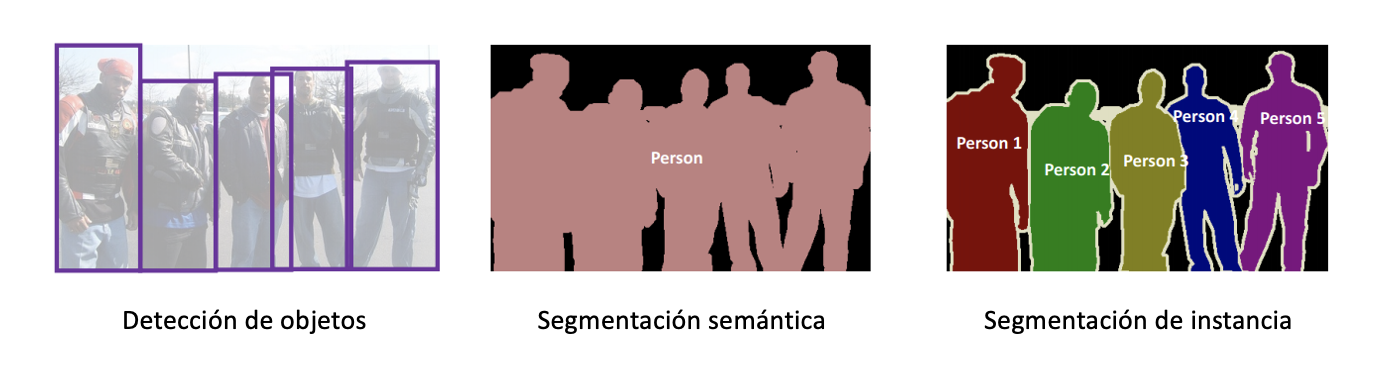



### SEGMENTACIÓN MEDIANTE THRESHOLDING

In [ ]:
import matplotlib.pyplot as plt
import cv2

# Read an image
img = cv2.imread('images/figuras.png')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb, cmap='gray')
plt.title('Imagen original')
plt.show()

In [ ]:
# Convertimos la imagen a escala de grises
import numpy as np
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Lo pasamos a Gris
plt.imshow(gray_img, cmap='gray')
plt.title('Imagen de grises')
plt.show()

In [ ]:
# Calculamos el histograma
"""
cv2.calcHist(images, channels, mask, histSize, range)

    images
    : Esta es la imagen para la que queremos calcular un histograma. Envuélvalo como una lista: [myImage]
    
    channels 
    : Una lista de índices, donde especificamos el índice del canal para el que queremos calcular un histograma. Para calcular un histograma de una imagen en escala de grises, la lista sería [0]
    . Para calcular un histograma para los tres canales rojo, verde y azul, la lista de canales sería [0, 1, 2]

    mask
    : ¿Recuerda haber aprendido acerca de las máscaras en mi guía de Enmascaramiento de imágenes con OpenCV? Bueno, aquí podemos suministrar una máscara. Si se proporciona una máscara, se calculará un histograma solo para los píxeles enmascarados. Si no tenemos una máscara o no queremos aplicar una, podemos proporcionar un valor de Ninguno
    
    
    histSize
    : Este es el número de contenedores que queremos usar al calcular un histograma. Nuevamente, esta es una lista, una para cada canal para el que estamos calculando un histograma. Los tamaños de contenedores no tienen que ser todos iguales. Aquí hay un ejemplo de 32 contenedores para cada canal: [32, 32, 32]


    range
    : El rango de posibles valores de píxeles. Normalmente, esto es [0, 256] (eso no es un error tipográfico, el rango final de cv2.calcHist
    La función no es inclusiva, por lo que querrá proporcionar un valor de 256 en lugar de 255) para cada canal, pero si está utilizando un espacio de color que no sea RGB [como HSV], los rangos pueden ser diferentes).

"""


hist = cv2.calcHist([gray_img], [0], None, [256], [0, 256]) # [0] son los canales, None la máscara



plt.plot(hist)
plt.grid()
plt.title('Histograma')
plt.show()


In [ ]:
# Fijamos el umbral en base al histograma anterior
t = 50

# Extreaemos la máscara binaria
maxim = 255 #Aquí puedo definir el valor máximo que puede tener la máscara, en este caso binario, 0 y 1
_, mask = cv2.threshold(gray_img, t, maxim, cv2.THRESH_BINARY)

# Visualizamos para corroborar
plt.imshow(mask, cmap='gray')
plt.title('Máscara t=' + str(t))
plt.show()

print(np.unique(mask))

## Fijar umbral mediante método OTSU de forma automática

Ahora bien, es posible que necesitemos automatizar el proceso de segmentación de las imágenes sin parametrizar el threshold de forma manual.

El método de Otsu es un procedimiento no paramétrico que permite obtener el umbral óptimo maximizando la varianza entre clases. Búsqueda exhaustiva. 
Se parte de una imagen con N píxeles que puede tomar L valores de grises diferentes.


In [ ]:
# Fijamos el umbral con el método de OTSU
t, mask = cv2.threshold(gray_img,0,1,cv2.THRESH_OTSU) # 0 es por defecto y 1 es el valor máximo de la máscara
#t, mask = cv2.threshold(gray_img,0,1,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
print(np.unique(mask))

# Visualizamos para corroborar que se obtiene el mismo resultado
plt.imshow(mask, cmap='gray')
plt.title('Máscara Otsu t=' + str(t))
plt.show()

### SEGMENTACIÓN MEDIANTE CONVERSIONES DE COLOR

In [ ]:
# Imaginamos que queremos segmentar únicamente el círculo
img = cv2.imread('images/figuras.png')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb, cmap='gray')
plt.title('Imagen original')
plt.show()

In [ ]:
# Obtenemos el canal rojo
R = img[:,:,2]
plt.imshow(R, cmap='gray')
plt.title('Canal rojo')
plt.show()

In [ ]:
# Observamos el histograma
plt.hist(R.ravel(), bins=50)
plt.grid(True)
plt.show()
print(np.max(R))

In [ ]:
# Fijamos el umbral y extraemos la máscara
t=np.max(R) #Umbral
mask = R.copy()
mask[mask<t] = 0 #Lo que esta por debajo de la máscara lo pongo a 0
plt.imshow(mask, cmap='gray')
plt.title('ROI segmentada')
plt.show()

In [ ]:
# Obtener una máscara con la imagen del rayo azul mediante segmentación por espacio de color
# Función para extraer los colores secundarios
import matplotlib.pyplot as plt
import cv2
import numpy as np

def convert_to_CMYK(rgb_p):
    with np.errstate(invalid='ignore', divide='ignore'):
        K = 1 - np.max(rgb_p, axis=2)
        C = (1-rgb_p[:,:,0] - K)/(1-K)
        M = (1-rgb_p[:,:,1] - K)/(1-K)
        Y = (1-rgb_p[:,:,2] - K)/(1-K)
    CMYK = (np.dstack((C,M,Y,K)))
    return CMYK

# Leer la imagen 
img = cv2.imread('images/figuras.png')
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
rgb_p = rgb.astype('uint8')/255

# Extraer los colores secundarios
CMYK = convert_to_CMYK(rgb_p)

# Extraer los canales por separado
C,M,Y,K = cv2.split(CMYK)
C = C.astype('uint8')

# Calcular la máscara de la figura del rayo
t, mask = cv2.threshold(C,0,1,cv2.THRESH_OTSU)

t=np.max(C) #Umbral
mask = C.copy()
mask[mask<t] = 0

# Visualizar la máscara
plt.imshow(C, cmap='gray')
plt.title('ROI segmentada')
plt.show()

## SEGMENTACIÓN SEMÁNTICA CON DETECCIÓN DE BORDES

Canny Edge Detection es un popular algoritmo de detección de bordes. Fue desarrollado por John F. Canny.

Es un algoritmo de varias etapas y pasaremos por cada una de ellas.

### Reducción de ruido

Dado que la detección de bordes es susceptible al ruido en la imagen, el primer paso es eliminar el ruido en la imagen con un filtro gaussiano de 5x5. 

## Encontrar el gradiente de intensidad de la imagen

Luego, la imagen suavizada se filtra con un núcleo Sobel en dirección horizontal y vertical para obtener la primera derivada en dirección horizontal (Gx) y dirección vertical (Gy). A partir de estas dos imágenes, podemos encontrar el degradado del borde y la dirección de cada píxel de la siguiente manera:

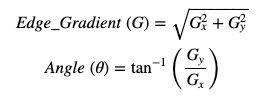

La dirección del degradado siempre es perpendicular a los bordes. Se redondea a uno de los cuatro ángulos que representan las direcciones vertical, horizontal y dos diagonales.

### Supresión no máxima

Después de obtener la magnitud y la dirección del gradiente, se realiza un escaneo completo de la imagen para eliminar los píxeles no deseados que pueden no constituir el borde. Para esto, en cada píxel, se verifica si el píxel es un máximo local en su vecindad en la dirección del gradiente. Revisa la imagen a continuación:

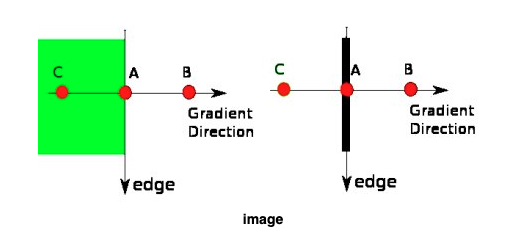

El punto A está en el borde (en dirección vertical). La dirección del degradado es normal al borde. Los puntos B y C están en direcciones de gradiente. Entonces, el punto A se verifica con el punto B y C para ver si forma un máximo local. Si es así, se considera para la siguiente etapa, de lo contrario, se suprime (se pone a cero).

En resumen, el resultado que obtiene es una imagen binaria con "bordes delgados".


### Umbral de histéresis

Esta etapa decide cuáles son todos los bordes que son realmente bordes y cuáles no. Para esto, necesitamos dos valores de umbral, minVal y maxVal. Cualquier borde con un gradiente de intensidad superior a maxVal seguramente será borde y aquellos por debajo de minVal seguramente no serán bordes, por lo tanto, deséchelos. Aquellos que se encuentran entre estos dos umbrales se clasifican como bordes o no bordes en función de su conectividad. Si están conectados a píxeles de "borde seguro", se consideran parte de los bordes. De lo contrario, también se desechan. Vea la imagen a continuación:

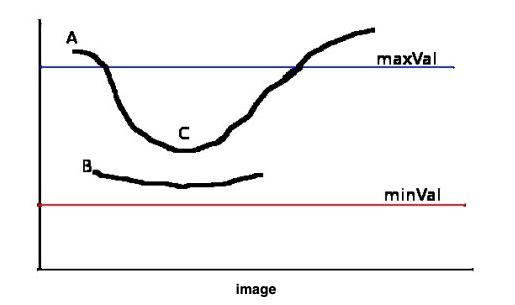


El borde A está por encima de maxVal, por lo que se considera "borde seguro". Aunque el borde C está por debajo de maxVal, está conectado al borde A, por lo que también se considera un borde válido y obtenemos esa curva completa. Pero el borde B, aunque está por encima de minVal y está en la misma región que el borde C, no está conectado a ningún "borde seguro", por lo que se descarta. Por lo tanto, es muy importante que seleccionemos minVal y maxVal en consecuencia para obtener el resultado correcto.

Esta etapa también elimina los ruidos de los píxeles pequeños asumiendo que los bordes son líneas largas.

In [ ]:
# SEGMENTACIÓN SEMÁNTICA CON DETECCIÓN DE BORDES
img = cv2.imread('images/figuras.png')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.title('Imagen original')
plt.show()

In [ ]:
# Aplicamos un filtro gaussiano para emborronar las altas frecuencias
img_gaus = cv2.GaussianBlur(img_rgb, (5,5), 0) # (5x5) es el tamaño del filtro y 0 es la desviación estándar
plt.imshow(img_gaus, cmap='gray')
plt.show()

In [ ]:
# Detección de bordes de Canny
canny = cv2.Canny(img_gaus, 255/3, 255) # minValue and maxValue. Canny recomienda que minValue sea 3 veces mayor que maxValue
kernel = np.ones((2,2), 'uint8')
#canny = cv2.dilate(canny, kernel, iterations=2) ## Me permite hacer más gruesos los bordes
#canny = cv2.erode(canny, kernel, iterations=2) ## Me permite hacer afinar los bordes

plt.imshow(canny, cmap='gray')
plt.show()

In [ ]:
# Rellenar objetos (solo rellena si no están en contacto con el límite de la imagen)
from scipy.ndimage.morphology import binary_fill_holes as bfh
bordes = canny.copy()
filled_bordes = bfh(bordes)

plt.imshow(filled_bordes.astype('uint8'), cmap='gray')
plt.title('cleaned lumen mask')
plt.show()

### SEGMENTACIÓN POR CRECIMIENTO DE REGIONES (region growing)

In [ ]:
#!pip install scikit-image
# Cargar imagen
from skimage import io
import cv2
import numpy as np
import matplotlib.pyplot as plt
img = cv2.imread('images/estrellas.png', 0)

plt.imshow(img, cmap='gray')
plt.show()

In [ ]:
# Crear una copia de la imagen
mask = img.copy()

# Definir una imagen negra de referencia
h, w = img.shape
ref = np.zeros((h+2, w+2), np.uint8)

# Fijar la semilla. En este caso en la esquina superior izquierda (posición 0,0) para rellenar a partir de ahí
cv2.floodFill(mask, ref, (0,0), 0); # Como nos interesa rellenar de negro, utilizamos el 0 en la última posición

fig, ax = plt.subplots(1,2)
ax[0].imshow(img, cmap='gray'), ax[0].set_title('original')
ax[1].imshow(mask, cmap='gray'), ax[1].set_title('máscara')
plt.show()